# Analysis of Physical Monitoring Dataset : Physical Activity Monitoring

## Noah Malancinas
### Overview
#### Background: 

The PAMAP2 Physical Activity Monitoring dataset , contains data of 18 different physical activities (such as walking, cycling, playing soccer etc) performed by 9 subjects wearing 3 Inertial Measurement Units (IMU) and a heart rate monitor. This data is stored in individual text files per subject. Each row in each file represents one reading and contains 54 attributes (including timestamp, activity ID, heart rate and IMU sensory data).
#### Sources:
1. A. Reiss and D. Stricker. Introducing a New Benchmarked Dataset for Activity Monitoring. The 
16th IEEE International Symposium on Wearable Computers (ISWC), 2012.
2. A. Reiss and D. Stricker. Creating and Benchmarking a New Dataset for Physical Activity 
Monitoring. The 5th Workshop on Affect and Behaviour Related Assistance (ABRA), 2012.

#### Target:
Assuming the goal is to develop hardware and/or software which can determine the amount and type of physical activity carried out by an individual, what actionable insights can you derive from the dataset?

#### Full information found here https://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring

## Contents
 ### Section 1) Data Munging
 
 ### Section 2) Data Analysis
   #### Amount of Activity Calculator
   #### Heart Rate Analysis
   #### Temperature Analysis
   #### Data Splitting and Correlation test
   
 ### Section 3) Hypothesis Testing
   #### Hypothesis 1: If increased heart rate reduces hand temperature then activites which are more physically demanding will in turn have lower hand temperature.
   #### Hypothesis 2: If activity 1 rejected the previous null hypothesis then the mean heart rate of activity 1 (laying) is higher than the mean heart rate of activity 2 (sitting).
   
   ### Section 4) Classification
   #### Logistic Regression - training models on different data
   #### KMeans Clustering
   #### Decision Tree
   
  ### Section 5) Conclusion
   
  
   
 

### Introduction

This report is based on the data extracted from the PAMPA2 physical activity monitoring dataset. I will analyse this data for the targe specified above.

In **section 1** I perform data munging which is a requirement before any exploratory data analysis can be carried out. Files were imported based on the recording details outlined in the brief. I remove all irrelevant rows where subjects did not perform activities. From the PDF information provided I used a third-party source to convert it to a CSV file, in this section I additionally load in these tables as data frames. I also calculate mean values for each IMU (Inertial Measurement Unit). This provides more data and confidently assisted me in structuring the final classification section.

In **section 2** Data analysis was carried out with hypothesis testing. I explored the amount of data recorded for every activity as well as the amount available from each subject. Further analysis leads to an exploration of the mean heart rate for those activities (figure 2 and 3). I further went on to analyse the different temperatures that the three different locations output for each individual subject (figure 4). This was taken further to show specific activities and their corresponding average temperature for each of the IMU locations (figure 5,6,7). Further from this, the developing and testing set was generated and I used a heat map (figure 8) on the split data to display any correlation between features which was then tested on the other set in section 3.

In **section 3** The hypothesis test was conducted. I found from the heat map in section 2 that there was a correlation between heart rate and hand temperature. I used bootstrap to avoid bias and additionally tested the hypothesis on unseen data. I tested the hypothesis on every activity in order and displayed the results of the probability value (Figures 9 and 10).


In **Section 4** I created supervised (Logistic Regression, Decision Tree) and unsupervised (KMeans Cluster) classification algorithms with development and testing data. Hypoerparameters were tuned for the Logistic Regression model. I explore the accuracy, precision, recall, and F1 metrics. In the case of KMeans, the silhouette score metric and adjusted rand score was used.



### Section 1: Data Munging

In [1]:
candidateno=244816 #this MUST be updated to your candidate number so that you get a unique data sample


In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import random 
import seaborn as sns
import scipy as scipy
from scipy import stats
from scipy.stats import t
import math
import statistics
import sklearn.metrics as metrics
from statsmodels.stats.weightstats import ztest 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score , precision_score, recall_score, f1_score
import sklearn.model_selection as cross_validation
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from collections import defaultdict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import silhouette_score , silhouette_samples
from sklearn.metrics.cluster import adjusted_rand_score
import sklearn.tree 
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

In [3]:
random.seed(candidateno)

In [4]:
list_of_files = ["Protocol/subject101.dat",
                "Protocol/subject102.dat",
                "Protocol/subject103.dat",
                "Protocol/subject104.dat",
                "Protocol/subject105.dat",
                "Protocol/subject106.dat",
                "Protocol/subject107.dat",
                "Protocol/subject108.dat",
                "Protocol/subject109.dat",
                "Optional/subject101.dat",
                "Optional/subject105.dat",
                "Optional/subject108.dat",
                "Optional/subject109.dat"]

activityID = {0: 'transient', 1: 'lying', 2: 'sitting', 3: 'standing', 4: 'walking', 5: 'running',
              6: 'cycling', 7: 'Nordic_walking', 9: 'watching_TV', 10: 'computer_work', 11: 'car driving', 
              12: 'ascending_stairs', 13: 'descending_stairs', 16: 'vacuum_cleaning', 17: 'ironing',
              18: 'folding_laundry', 19: 'house_cleaning', 20: 'playing_soccer', 24: 'rope_jumping'}
# These were the only activities performed by the subjects
compulsory_activities = [1,2,3,17,16,12,13,4,7,6,5,24]
                  
columnNames= ["timestamp", "activityID", "heartrate"]
                  
IMU_hand = ['handTemp', 
           'handAc16_1', 'handAc16_2', 'handAc16_3', 
           'handAc6_1', 'handAc6_2', 'handAc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMag1', 'handMag2', 'handMag3',
           'handOri1', 'handOri2', 'handOri3', 'handOri4']

IMU_chest = ['chestTemp', 
           'chestAc16_1', 'chestAc16_2', 'chestAc16_3', 
           'chestAc6_1', 'chestAc6_2', 'chestAc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMag1', 'chestMag2', 'chestMag3',
           'chestOri1', 'chestOri2', 'chestOri3', 'chestOri4']

IMU_ankle = ['ankleTemp', 
           'ankleAc16_1', 'ankleAc16_2', 'ankleAc16_3', 
           'ankleAc6_1', 'ankleAc6_2', 'ankleAc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMag1', 'ankleMag2', 'ankleMag3',
           'ankleOri1', 'ankleOri2', 'ankleOri3', 'ankleOri4']
                  
cols= columnNames + IMU_hand + IMU_chest + IMU_ankle

METless3 = [0,1,2,3,9,10,17,18] #categories the data into 3 groups to determine which activity is being performed later
METless7 = [4,7,6,11,13,16,19]
METless8 = [5,12,20,24]

MET above found from the "Description Of Activities" aswell as the reference [2] in the reference section.

In [5]:
def activityclassify(ID): #function to assist with mapping later.
    if ID in METless3:
        return "Light Activity"
    if ID in METless7:
        return "Moderate Activity"
    if ID in METless8:
        return "Vigorous Activity"

Classifying the activities into 3 different groups. This will allow clustering and classifier training to more accuratly put activities into their activity category. Here I have used 3 classes 0< MET <3, 3$\leq$ MET< 7, 7$\leq$ MET <8.

In [6]:
pamap2_df = pd.DataFrame() #turning the data into a data frame using the specified detail.
for file in list_of_files:
    subject_data =pd.read_table(file, header = None, sep="\s+")
    subject_data.columns = cols
    subject_data["subjectID"] = int(file[-5]) #from the record books
    subject_data["ActivityDifficulty"] = subject_data["activityID"].apply(activityclassify) #using a "map" to transform data
    pamap2_df =pamap2_df.append(subject_data, ignore_index=True)
    

In [7]:
def mean_calc(name): #used to find the mean and append to the big data frame to gather more information and make analysis accurate.
    pamap2_df[name+'mean_acc16']=(pamap2_df[name+'Ac16_1'].astype(float)+pamap2_df[name+'Ac16_2'].astype(float)
                                     +pamap2_df[name+'Ac16_3'].astype(float))/3 #finds mean for each row and creates new column
    pamap2_df[name+'mean_gyro']=(pamap2_df[name+'Gyro1'].astype(float)+pamap2_df[name+'Gyro2'].astype(float)
                                    +pamap2_df[name+'Gyro3'].astype(float))/3
    pamap2_df[name+'mean_mag']=(pamap2_df[name+'Mag1'].astype(float)+pamap2_df[name+'Mag2'].astype(float)
                                   +pamap2_df[name+'Mag3'].astype(float))/3
    pamap2_df[name+'mean_temp']=(pamap2_df[name+'Temp'].astype(float)+pamap2_df[name+'Temp'].astype(float)
                                   +pamap2_df[name+'Temp'].astype(float))/3

In [8]:
mean_calc("hand")
mean_calc("chest")
mean_calc("ankle")

In [9]:
#From the "read me" file the following columns below are to be removed due to being invalid in this experiment & report
pamap2_df = pamap2_df.drop(columns=['handAc6_1', 'handAc6_2', 'handAc6_3','handOri1','handOri2','handOri3',
                        'chestAc6_1', 'chestAc6_2', 'chestAc6_3','chestOri1', 'chestOri2', 'chestOri3', 'chestOri4',
                       'ankleAc6_1', 'ankleAc6_2', 'ankleAc6_3','ankleOri1', 'ankleOri2', 'ankleOri3', 'ankleOri4'])
pamap2_df = pamap2_df.interpolate(method="linear")

In [10]:
#the transient activities are irellevant and need to be removed
pamap2_df = pamap2_df.drop((pamap2_df.index[pamap2_df.activityID==0]))

In [11]:
def drop_pamap2(subject,activities):
    a = pamap2_df.drop((pamap2_df.index[(pamap2_df['subjectID']==subject) & (pamap2_df.activityID.isin([activities]))])) 
    return a

In [12]:
# Not all subjects performed every activity and below I filter out those activities that specific subjects did not complete.
# All columns to drop are found in "PerformedActivitiesSummary"
pamap2_df = drop_pamap2(1,[10,20])
pamap2_df = drop_pamap2(2,[9,10,11,18,19,20])
pamap2_df = drop_pamap2(3,[5,6,7,9,10,11,18,19,20,24])
pamap2_df = drop_pamap2(4,[5,9,10,11,18,19,20,24])
pamap2_df = drop_pamap2(5,[9,11,18,20])
pamap2_df = drop_pamap2(6,[9,11,20])
pamap2_df = drop_pamap2(7,[9,10,11,18,19,20,24])
pamap2_df = drop_pamap2(8,[9,11])
pamap2_df = drop_pamap2(9,[1,2,3,4,5,6,7,9,11,12,13,16,17])

In [13]:
pamap2_df.reset_index(inplace = True)
pamap2_df = pamap2_df.drop(columns= "index") #Last section just created a new index and moved the old one into a column
pamap2_df.isnull().sum()

timestamp             0
activityID            0
heartrate             0
handTemp              0
handAc16_1            0
handAc16_2            0
handAc16_3            0
handGyro1             0
handGyro2             0
handGyro3             0
handMag1              0
handMag2              0
handMag3              0
handOri4              0
chestTemp             0
chestAc16_1           0
chestAc16_2           0
chestAc16_3           0
chestGyro1            0
chestGyro2            0
chestGyro3            0
chestMag1             0
chestMag2             0
chestMag3             0
ankleTemp             0
ankleAc16_1           0
ankleAc16_2           0
ankleAc16_3           0
ankleGyro1            0
ankleGyro2            0
ankleGyro3            0
ankleMag1             0
ankleMag2             0
ankleMag3             0
subjectID             0
ActivityDifficulty    0
handmean_acc16        0
handmean_gyro         0
handmean_mag          0
handmean_temp         0
chestmean_acc16       0
chestmean_gyro  

In [14]:
pamap2_df.head(10)

,timestamp,activityID,heartrate,handTemp,handAc16_1,handAc16_2,handAc16_3,handGyro1,handGyro2,handGyro3,...,handmean_mag,handmean_temp,chestmean_acc16,chestmean_gyro,chestmean_mag,chestmean_temp,anklemean_acc16,anklemean_gyro,anklemean_mag,anklemean_temp
0,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,...,-26.325367,30.375,2.707567,0.000145,-1.962178,32.1875,2.662032,-0.007684,-52.113767,30.75
1,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,...,-26.428167,30.375,2.733360,-0.021601,-2.020103,32.1875,2.597479,0.009278,-51.858967,30.75
2,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,...,-25.951613,30.375,2.703949,-0.003142,-2.079840,32.1875,2.571709,-0.030899,-51.578933,30.75
3,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,...,-26.023973,30.375,2.744582,-0.035405,-2.057705,32.1875,2.636982,-0.008136,-51.915767,30.75
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,...,-26.037313,30.375,2.796648,-0.017464,-2.441961,32.1875,2.661912,-0.017951,-51.737067,30.75
5,37.71,1,100.0,30.375,2.07165,7.25965,6.01218,0.063895,0.007175,0.024701,...,-25.985417,30.375,2.692244,-0.022033,-1.745760,32.1875,2.546056,-0.006329,-52.016733,30.75
6,37.72,1,100.0,30.375,2.41148,7.59780,5.93915,0.190837,0.003116,0.038762,...,-25.888090,30.375,2.719844,-0.010527,-2.052567,32.1875,2.583989,-0.000776,-52.170300,30.75
7,37.73,1,100.0,30.375,2.32815,7.63431,5.70686,0.200328,-0.009266,0.068567,...,-26.164273,30.375,2.758798,-0.006539,-2.140302,32.1875,2.545574,-0.006808,-52.364967,30.75
8,37.74,1,100.0,30.375,2.25096,7.78598,5.62821,0.204098,-0.068256,0.050000,...,-26.078073,30.375,2.744796,-0.012494,-2.424282,32.1875,2.700327,0.015953,-52.356133,30.75
9,37.75,1,100.0,30.375,2.14107,7.52262,5.78141,0.171291,-0.055411,0.021576,...,-25.708747,30.375,2.642334,-0.013332,-2.123858,32.1875,2.596032,0.008081,-52.354033,30.75


There are still null values in the heart rate columns. This is because the linear method of interpolation uses the cells around those values to calculate what they should have been if they were values. "interpolation" makes estimates of a value inside of the data range. This is very accurate and not confused with its counter "extrapolate". Since above I have looked at the head of the data frame (first 10 values) It is safe to assume that these initial values had a heart rate of 100. I complete this task below.

In [15]:
indx = pamap2_df.index[:4] #only taking the first 4 rows which have missing heart rate
pamap2_df.loc[indx, 'heartrate'] = 100
pamap2_df.head()

,timestamp,activityID,heartrate,handTemp,handAc16_1,handAc16_2,handAc16_3,handGyro1,handGyro2,handGyro3,...,handmean_mag,handmean_temp,chestmean_acc16,chestmean_gyro,chestmean_mag,chestmean_temp,anklemean_acc16,anklemean_gyro,anklemean_mag,anklemean_temp
0,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,...,-26.325367,30.375,2.707567,0.000145,-1.962178,32.1875,2.662032,-0.007684,-52.113767,30.75
1,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,...,-26.428167,30.375,2.733360,-0.021601,-2.020103,32.1875,2.597479,0.009278,-51.858967,30.75
2,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,...,-25.951613,30.375,2.703949,-0.003142,-2.079840,32.1875,2.571709,-0.030899,-51.578933,30.75
3,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,...,-26.023973,30.375,2.744582,-0.035405,-2.057705,32.1875,2.636982,-0.008136,-51.915767,30.75
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,...,-26.037313,30.375,2.796648,-0.017464,-2.441961,32.1875,2.661912,-0.017951,-51.737067,30.75


In [16]:
def read_csv(data):
    df = pd.read_csv(data)
    return df

In [17]:
si_data = read_csv("subjectInformation.csv")

In [18]:
si_data.shape # note that I have removed the dominant hand column

(9, 7)

In [19]:
print(round(si_data.mean(),3))
si_data

SubjectID      5.000
Age           27.222
Height       179.444
Weight        80.889
RestingHR     65.000
MaxHR        192.778
dtype: float64


,SubjectID,Sex,Age,Height,Weight,RestingHR,MaxHR
0,1,Male,27,182,83,75,193
1,2,Female,25,169,78,74,195
2,3,Male,31,187,92,68,189
3,4,Male,24,194,95,58,196
4,5,Male,26,180,73,70,194
5,6,Male,26,183,69,60,194
6,7,Male,23,173,86,60,197
7,8,Male,32,179,87,66,188
8,9,Male,31,168,65,54,189


In [20]:
pas_data = read_csv("PAS.csv")
pas_data.shape
print('standard deviation of each subject:\n',pas_data[1:9].std())

standard deviation of each subject:
 subject101         241.735564
subject102         130.956631
subject103         137.572941
subject104         139.546724
subject105         327.238651
subject106         169.335960
subject107         135.894396
subject108         193.635765
subject109         242.357314
Sum                724.047745
Nr. of subjects      2.474874
dtype: float64


In [21]:
print("PAS Data")
pas_data


PAS Data


,Activities,subject101,subject102,subject103,subject104,subject105,subject106,subject107,subject108,subject109,Sum,Nr. of subjects
0,lying,271.86,234.29,220.43,230.46,236.98,233.39,256.10,241.64,0.00,1925.15,8.0
1,sitting,234.79,223.44,287.60,254.91,268.63,230.40,122.81,229.22,0.00,1851.80,8.0
2,standing,217.16,255.75,205.32,247.05,221.31,243.55,257.50,251.59,0.00,1899.23,8.0
3,walking,222.52,325.32,290.35,319.31,320.32,257.20,337.19,315.32,0.00,2387.53,8.0
4,running,212.64,92.37,0.00,0.00,246.45,228.24,36.91,165.31,0.00,981.92,6.0
5,cycling,235.74,251.07,0.00,226.98,245.76,204.85,226.79,254.74,0.00,1645.93,7.0
6,Nordic walking,202.64,297.38,0.00,275.32,262.70,266.85,287.24,288.87,0.00,1881.00,7.0
7,watching TV,836.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,836.45,1.0
8,computer work,0.00,0.00,0.00,0.00,1108.82,617.76,0.00,687.24,685.49,3099.31,4.0
9,car driving,545.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,545.18,1.0


As you can see above subjects 1,5,6 and 8 had the most recorded time. This would imply that once data is analysed their results would have the most value. Here we can see that Subject 9 had the lowest recorded time we can see that is due to the fact that they did not complete many of the light exercises (MET <3). Instead, they participated in a number of high-intensity activities such as soccer and rope jumping and only complete a couple of light exercises. This implies that the presence of subject 9 will gather incorrect information and thus they are to be removed.

In [22]:
pamap2_df = pamap2_df.drop(list(pamap2_df.index[(pamap2_df['subjectID']==9)])) # Removeing all data for subject 9

## Section 2: Data Analysis

### Amount of Physical Activity
From the Silverback Fitness (referenced at the end) it is stated that the amount of physical activity performed (measured in calories burnt) is the follow formula : (Activity Duration in minutes) x [(MET score x 3.5 x Weight in Kg)/200] $^{[4]}$

In [246]:
Caloriesdf= si_data[["SubjectID","Weight"]]
Caloriesdf= Caloriesdf.set_index("SubjectID")
Caloriesdf

,Weight
SubjectID,
1,83
2,78
3,92
4,95
5,73
6,69
7,86
8,87
9,65


In [247]:
activityandMET={"lying":1,"sitting":1.8,"standing":1.8,"ironing":2.3,
                "folding laundry":3.5,"ascending stairs":8,"descending stairs":3,
                "walking":3.55,"Nordic walking":5.5,"cycling":4,"running":7.5,"rope jumping":9}

In [248]:
activitydurations = pas_data.iloc[: ,:10]

In [249]:
activitydurations = activitydurations.rename(columns={"subject101":1,"subject102":2,"subject103":3,"subject104":4,
                                 "subject105":5,"subject106":6,"subject107":7,
                                 "subject108":8,"subject109":9})

In [250]:
activitydurations = activitydurations.set_index("Activities")

In [251]:
activitydurations

,1,2,3,4,5,6,7,8,9
Activities,,,,,,,,,
lying,271.86,234.29,220.43,230.46,236.98,233.39,256.10,241.64,0.00
sitting,234.79,223.44,287.60,254.91,268.63,230.40,122.81,229.22,0.00
standing,217.16,255.75,205.32,247.05,221.31,243.55,257.50,251.59,0.00
walking,222.52,325.32,290.35,319.31,320.32,257.20,337.19,315.32,0.00
running,212.64,92.37,0.00,0.00,246.45,228.24,36.91,165.31,0.00
cycling,235.74,251.07,0.00,226.98,245.76,204.85,226.79,254.74,0.00
Nordic walking,202.64,297.38,0.00,275.32,262.70,266.85,287.24,288.87,0.00
watching TV,836.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
computer work,0.00,0.00,0.00,0.00,1108.82,617.76,0.00,687.24,685.49


In [252]:
activitydurations[1]["lying"]

271.86

In [253]:
def findcalories(Subject,Activity):
    weight= 3.5* Caloriesdf.Weight[Subject] # from forumula
    MET = activityandMET[Activity]
    duration = (activitydurations[Subject][Activity] /60) #duration here is in seconds - change to minutes
    calories = (duration) * (weight*MET)/200
    if calories >0:
        print("The amount of calories burnt for Subject {}, performing the activity {} is {} Calories.".format(Subject,Activity,calories))
        
    else:
        print("Subject {}, did not perform the activity {}".format(Subject,Activity))
        
    return calories
    

In [254]:
findcalories(2,"sitting")

The amount of calories burnt for Subject 2, performing the activity sitting is 9.149868 Calories.


9.149868

In [255]:
findcalories(3,"rope jumping")

Subject 3, did not perform the activity rope jumping


0.0

In [256]:
for j in activityandMET.keys():
    print (j)

lying
sitting
standing
ironing
folding laundry
ascending stairs
descending stairs
walking
Nordic walking
cycling
running
rope jumping


In [257]:
def findcalories(Subject,Activity):
    a= str(Activity)
    weight= 3.5* Caloriesdf.Weight[Subject] # from forumula
    MET = float(activityandMET[a])
    duration = activitydurations[Subject][Activity]  #duration here is in seconds - change to minutes
    calories = (duration/60) * (weight*MET)/200        
    return calories
    

In [258]:
for j,word in enumerate((activityandMET.keys())):
    print("{}: {}".format(j,word))

0: lying
1: sitting
2: standing
3: ironing
4: folding laundry
5: ascending stairs
6: descending stairs
7: walking
8: Nordic walking
9: cycling
10: running
11: rope jumping


In [259]:
scores=np.zeros((10,len(activityandMET)))
for i in range(1,10):
    for j,word in enumerate((activityandMET.keys())):
        scores[i][j] = (findcalories(i,word))
        

In [260]:
scoresdf = pd.DataFrame(scores,columns=[i for i in activityandMET.keys()])
scoresdf = scoresdf.iloc[1:,:]

In [261]:
scoresdf

,lying,sitting,standing,ironing,folding laundry,ascending stairs,descending stairs,walking,Nordic walking,cycling,running,rope jumping
1,6.581278,10.230974,9.462747,13.124693,22.972619,30.769760,10.818946,19.123276,26.980672,22.827490,38.607450,28.129841
2,5.330098,9.149868,10.472963,15.110937,0.000000,31.558800,10.381508,26.273656,37.209673,22.847370,15.760631,27.151898
3,5.914872,13.891080,9.916956,17.264620,0.000000,22.297427,12.293960,27.658257,0.000000,0.000000,0.000000,0.000000
4,6.385663,12.713636,12.321619,15.928468,0.000000,37.000600,11.872744,31.408795,41.957621,25.156950,0.000000,0.000000
5,5.045699,10.295245,8.481706,16.176535,0.000000,24.321897,8.128094,24.211521,30.763265,20.930560,39.354984,14.816445
6,4.696974,8.346240,8.822599,17.470291,15.344809,21.395290,6.804263,18.375332,29.536959,16.490425,34.449975,0.461869
7,6.423842,5.544872,11.626125,17.017888,0.000000,35.405627,8.741040,30.025365,39.627152,22.754597,6.943694,0.000000
8,6.131615,10.469624,11.491373,19.253205,21.003268,23.712430,7.348346,28.404420,40.315419,25.856110,31.460559,20.108419
9,0.000000,0.000000,0.000000,0.000000,18.132603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.902938


The Above is my data frame to show you how many calories each subject (rows) burn performing differente activties. The activities displayed are not all the activities performed - however with my calulators which uses MET score this was not possible to do without having the predefined MET scores. It is clear to see that activites which induced more calories burn include Nordic walking, running and ascending stairs.

# EDA

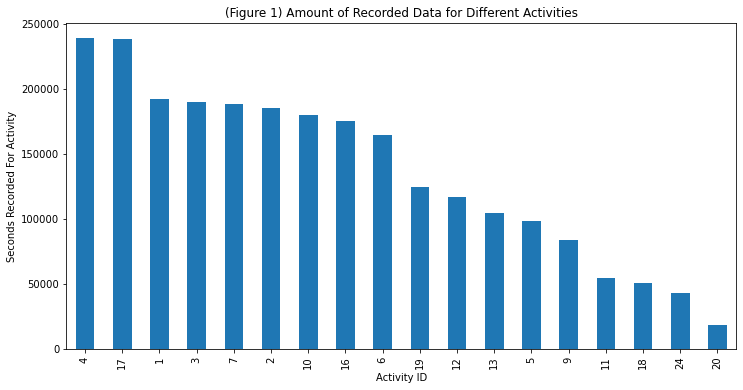

In [144]:
pamap2_df["activityID"].value_counts().plot(kind="bar",figsize=(12,6)) #using bar charts to visually display recorded data
plt.xlabel("Activity ID")
plt.ylabel("Seconds Recorded For Activity")
plt.title("(Figure 1) Amount of Recorded Data for Different Activities")
plt.show()

The above shows which activities have the most recorded time. Clearly, activities 4 and 17 which correspond to walking and ironing have the most data. Whereas rope jumping (Activity 24) does not have enough data therefore the dataset is imbalanced. However, there is still plenty to analyse.  Similarity from the PAS data frame you can see that Subject 109 did not complete much of the exercise and their recorded data is sparse.

### Heart Rate Analysis

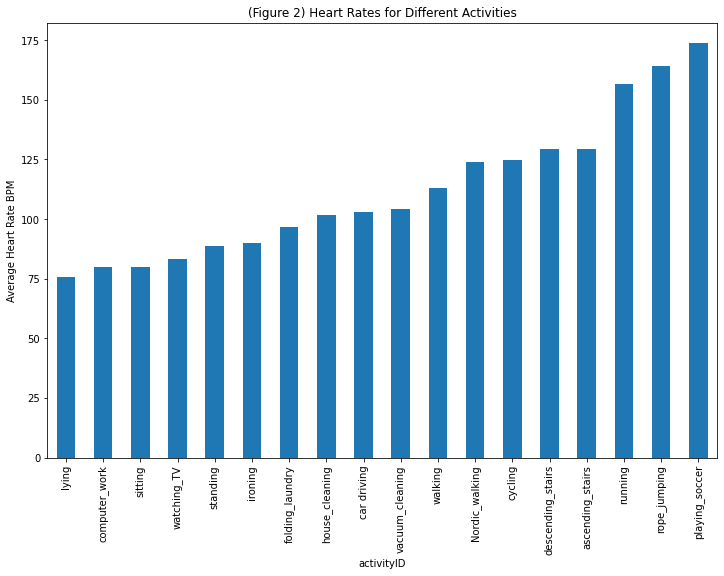

In [145]:
#here I group all activity ID to display the differences in heart rates
df_hr_act = pamap2_df['heartrate'].groupby(pamap2_df['activityID']).mean()
df_hr_act.index = df_hr_act.index.map(activityID)
df_hr_act = df_hr_act.sort_values()
df_hr_act.plot(kind = "bar", figsize= (12,8))
plt.ylabel("Average Heart Rate BPM")
plt.title("(Figure 2) Heart Rates for Different Activities")
plt.show()


The above simply shows that the activities of rope jumping and running were the most intense. The easiest activity "lying" had an average heart rate just slightly below 80. This is great information as the average resting heart rate is 65 BPM. This indicates that every activity including those that seemingly shouldn't affect heart rate had an increase in their heart rates.

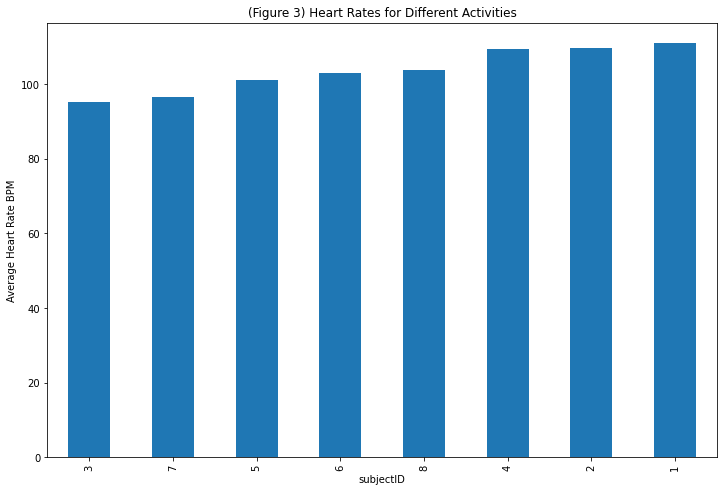

In [146]:
#here I group all subjects together to display the differences in heart rates
heart_rates = pamap2_df['heartrate'].groupby(pamap2_df['subjectID']).mean()
heart_rates = heart_rates.sort_values()
heart_rates.plot(kind = "bar", figsize= (12,8))
plt.ylabel("Average Heart Rate BPM")
plt.title("(Figure 3) Heart Rates for Different Activities")
plt.show()

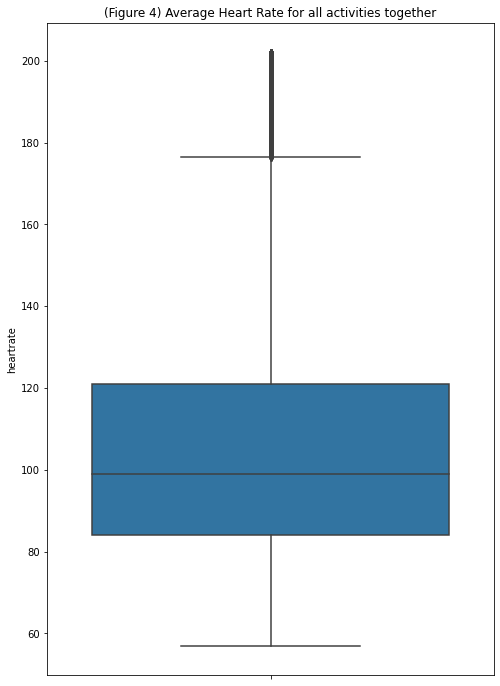

In [147]:
#box plot visualisation of average heart rate. All values outside the whisker are outliers
fig, ax = plt.subplots(figsize=(8,12)) 
plt.title("(Figure 4) Average Heart Rate for all activities together")
ax = sns.boxplot(y=pamap2_df["heartrate"])

From the above box plot it is clear to see that the heart rates had no skew which indicates that all the recorded activities are nicely spread out $\implies$ there are equal amounts of data for the range of activity difficulty.

In [148]:
def boxplot(df,by1,by2,figure): #method to display multiple box plots on one plot that are grouped by acitvityID
    pamap2_df.boxplot(by = by1,column=[by2],grid=True,figsize= (12,6))
    title_boxplot = figure
    plt.title(title_boxplot)
    plt.ylabel("Measured by {}".format(by2))
    plt.show()

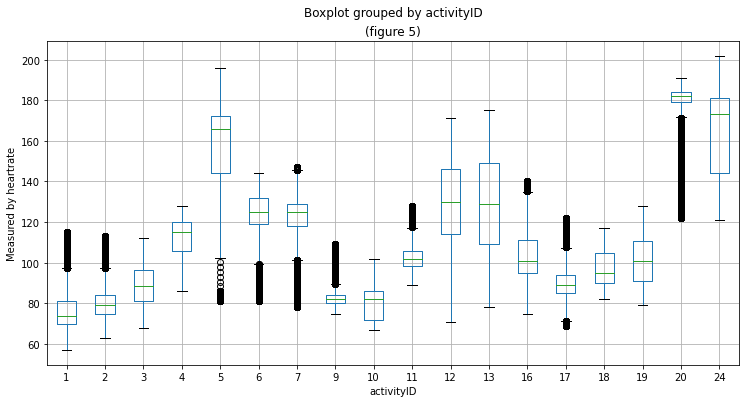

In [149]:
boxplot(pamap2_df,"activityID","heartrate", "(figure 5)")

As you can see activity 14 and 5 have the highest mean heart rates. From this, I will perform analysis to determine if these two are significantly more impactful on heart rate compared to weaker activity 1 or 2. My hypothesis determines that subjects that conducted activity 2 will have a warmer hand temperature than those in activity 24. Before I can do this I need to split the data into development and test sets.

### Temperature Analysis


In [150]:
idgrouped = pamap2_df.groupby(["subjectID"]).mean().reset_index() #allows me to select certain features from grouped subjectIDs

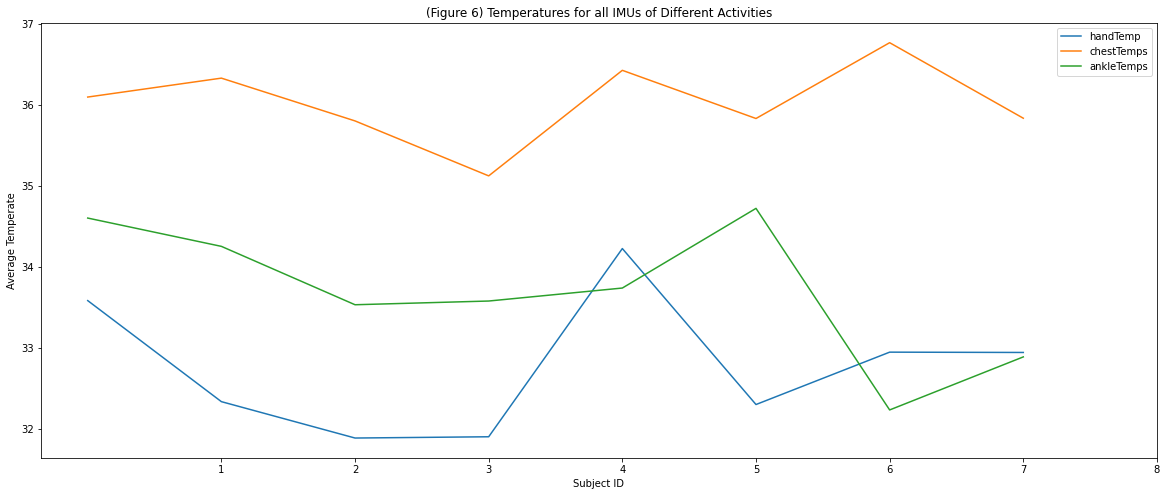

In [151]:
temps = pd.DataFrame()
temps["handTemp"] = idgrouped["handTemp"] #from grouped data I am able to select out the features I wish to display
temps["chestTemps"]= idgrouped["chestTemp"]
temps["ankleTemps"]= idgrouped["ankleTemp"]
axes = temps.plot(kind="line", figsize=(20,8), title= "(Figure 6) Temperatures for all IMUs of Different Activities")
plt.xticks(idgrouped["subjectID"]) #sorts the x labels
plt.ylabel("Average Temperate")
plt.xlabel("Subject ID")
plt.show()

Above we can see the average heart rates measured on all IMUS for the different participants. Subject Number 5 had the highest recorded hand temperature as well as the highest recorded ankle temperature. All the hand temperatures were very low compared to the average temperature normal temperature of $36 ^oC$ to  $35 ^oC$. Thus from the above analysis, I will take aim to look at hand temperature as the main research objective.

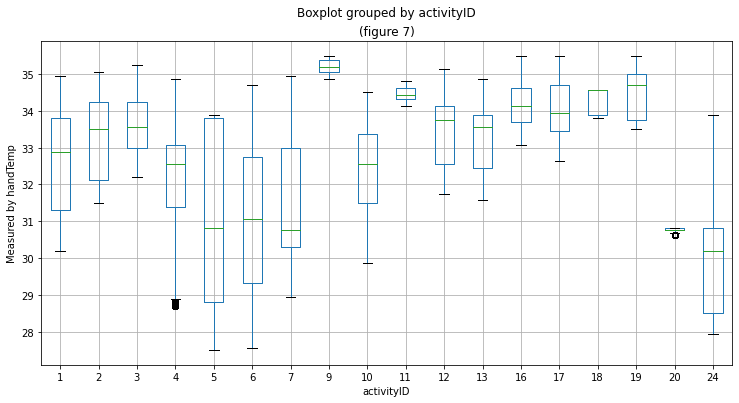

In [152]:
boxplot(pamap2_df,"activityID","handTemp","(figure 7)")

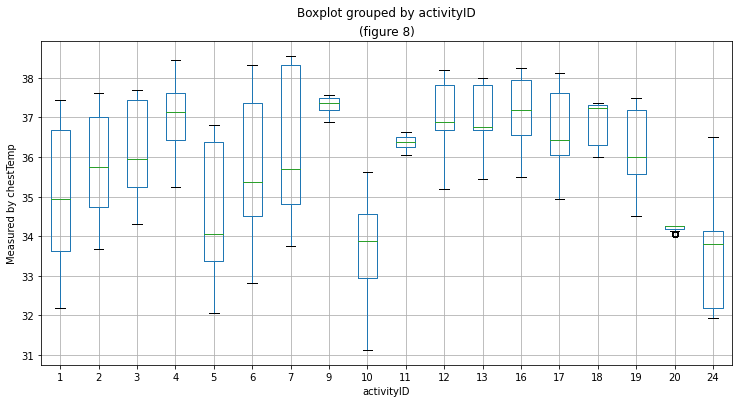

In [153]:
boxplot(pamap2_df,"activityID","chestTemp","(figure 8)")

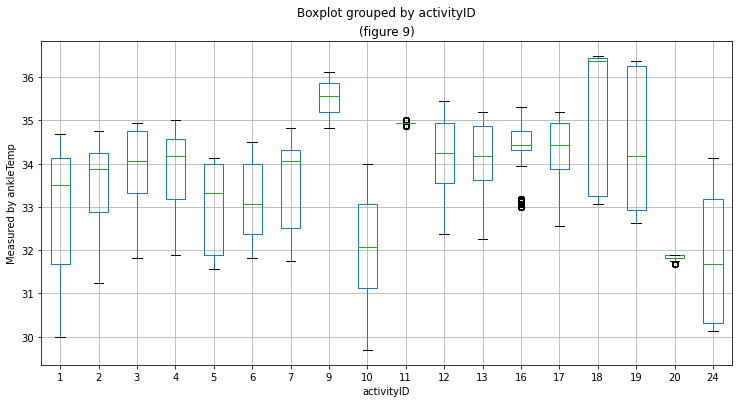

In [154]:
boxplot(pamap2_df,"activityID","ankleTemp","(figure 9)")

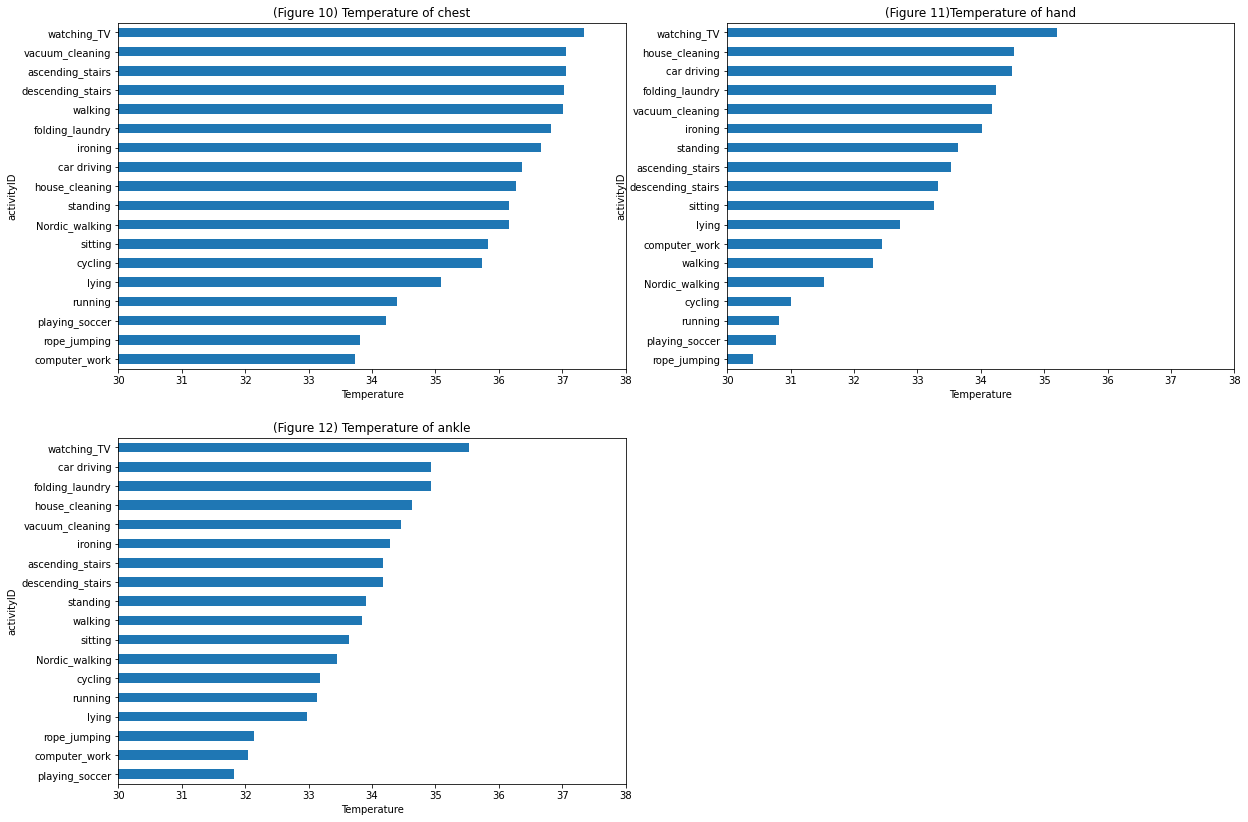

In [155]:
# plots to display the different activities with their respective temperatures
# this makes it easy to compare and contrast
plt.figure(figsize=(20,14))
plt.setp(ax, xlim=(30,40))
ax1=plt.subplot(221)
ax1.set_title('(Figure 10) Temperature of chest')
ax1.set_xlabel('Temperature')
pamap2_df["chestTemp"].groupby(pamap2_df.activityID.map(activityID)).mean().sort_values(ascending=True).plot(kind='barh')
ax1.set_xlim([30,38])
ax2 = plt.subplot(222)
ax2.set_title('(Figure 11)Temperature of hand')
ax2.set_xlabel('Temperature')
pamap2_df['handTemp'].groupby(pamap2_df.activityID.map(activityID)).mean().sort_values(ascending=True).plot(kind='barh')
ax2.set_xlim([30,38])
ax3= plt.subplot(223)
ax3.set_title('(Figure 12) Temperature of ankle')
ax3.set_xlabel('Temperature')
pamap2_df['ankleTemp'].groupby(pamap2_df.activityID.map(activityID)).mean().sort_values(ascending=True).plot(kind='barh')
ax3.set_xlim([30,38])
plt.show()

From the above figures, we notice that different activities affect the IMU heat sensors differently. All the charts show that activity 17 (Vacuum Cleaning) causes the highest temperature in the body overall. Similarly, activity 24 (Jump Rope) has the opposite effect, the temperature over the sensors was the lowest. From the temperature analysis 24 (Rope Jump), 5 (Running), and 6 (Cycling) were consistently at the lower end of the temperature - always being in the lowest 4 recorded. These were the activities that were listed as "Vigorous Activities" which leads me to my hypothesis in the next section.

I will perform a quick correlation test using the test set. This test data frame is small and should provide me with a sufficient hypothesis basis to then further test the assumptions made from this data frame. The heat map method is the most efficient way to quickly spot correlations between different features.

#### Development and Testing split
Usually a 70/30 split is normal however, the sample size here is very small so I have opted for a 80/20 split to get more accurate measurements.

In [156]:
dev_df = pamap2_df.sample(frac=0.8,random_state=1) #fractional split of data 80/20 allows more training data
test_df = pamap2_df.drop(dev_df.index)

In [157]:
dev_df.head(5)

,timestamp,activityID,heartrate,handTemp,handAc16_1,handAc16_2,handAc16_3,handGyro1,handGyro2,handGyro3,...,handmean_mag,handmean_temp,chestmean_acc16,chestmean_gyro,chestmean_mag,chestmean_temp,anklemean_acc16,anklemean_gyro,anklemean_mag,anklemean_temp
1666600,2998.83,6,121.0,32.6875,-0.345451,4.05097,9.951000,0.429572,0.216456,0.190818,...,-15.855767,32.6875,1.269867,0.259798,-8.421523,37.6250,3.221123,0.371868,-7.378983,32.1250
1101093,2482.12,4,115.0,34.6875,-6.983330,2.38916,0.774151,-0.900728,-0.235042,2.055680,...,-5.587467,34.6875,3.801073,0.016640,-10.309800,38.3125,2.559825,-0.512064,-20.804823,34.3125
798258,1298.85,16,118.0,33.6875,-9.550300,6.32152,5.456380,0.936809,-0.673681,0.097682,...,11.768347,33.6875,-5.665353,0.096961,24.973416,36.0000,4.359142,0.002954,-3.094933,34.4375
1501381,736.38,3,76.0,33.2500,-9.296610,2.64193,1.546880,0.200403,-0.121450,0.064111,...,2.165473,33.2500,3.802233,-0.093859,-13.351650,35.9375,1.662009,-0.021685,3.555903,32.5000
1092386,2395.05,4,111.0,34.6250,-16.815900,9.56608,5.490550,-2.144350,0.028900,-6.196890,...,0.034267,34.6250,3.816830,-0.245351,-7.704833,38.1875,-2.405777,-0.128600,-13.774567,34.1250


In [158]:
pamap2_df.describe().loc["mean"]

timestamp          1609.095045
activityID            9.125781
heartrate           104.405717
handTemp             32.977092
handAc16_1           -4.011723
handAc16_2            3.562060
handAc16_3            3.786102
handGyro1             0.001428
handGyro2             0.038767
handGyro3            -0.006374
handMag1             18.634835
handMag2            -15.729340
handMag3            -24.118974
handOri4             -0.080505
chestTemp            36.056393
chestAc16_1           0.372890
chestAc16_2           8.139194
chestAc16_3          -1.048423
chestGyro1            0.004534
chestGyro2            0.006470
chestGyro3           -0.020989
chestMag1             2.824871
chestMag2           -30.858604
chestMag3             3.517788
ankleTemp            33.742862
ankleAc16_1           8.990916
ankleAc16_2          -0.420597
ankleAc16_3          -2.784280
ankleGyro1            0.007327
ankleGyro2           -0.028484
ankleGyro3            0.005551
ankleMag1           -29.619750
ankleMag

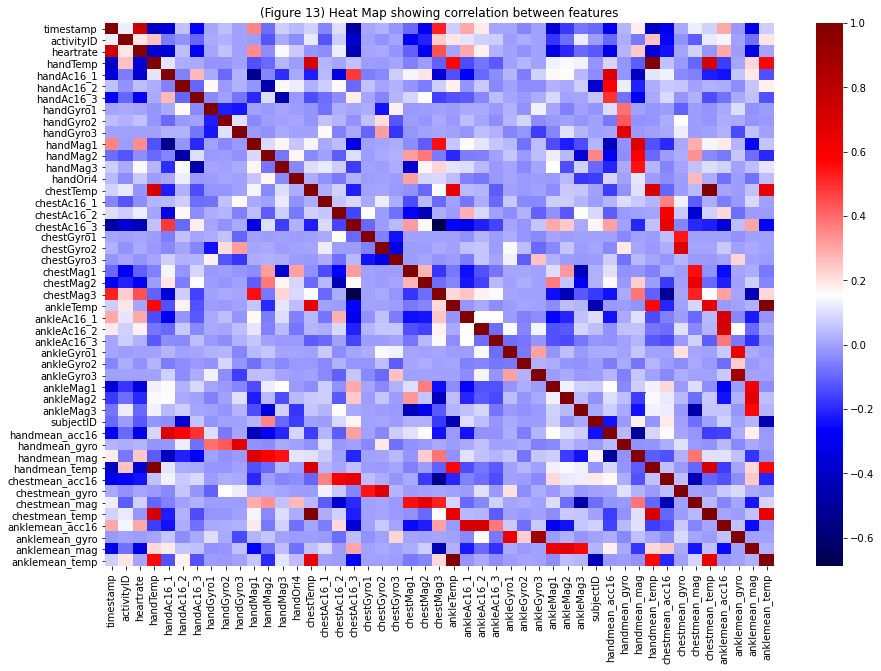

In [159]:
pamap2_corr = test_df.corr() #quick correlation check
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(pamap2_corr,mask=np.zeros_like(pamap2_corr),cmap = "seismic",ax=ax) #seaborn is an easy way to plot the heat map
plt.title("(Figure 13) Heat Map showing correlation between features")
plt.show()

From the above, it is noticeable that heart rate and hand temp are strongly negatively correlated. Thus I wish to see if those activities that had lower recorded hand temperature also had higher heart rates. And thus inturn implies that activities that are more physically demanding will result in hand temperature decreasing.

Below I will perform another heat map to quickly and fairly accurately analyse the correlation between the features of heart rate with activity ID and subject ID, Then I move on to Hand temperature against the same variables. This will give me a basis to make further analysis in the section to follow.

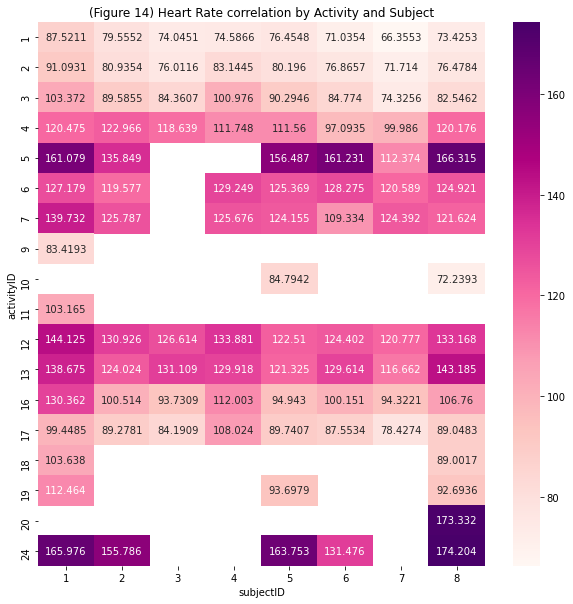

In [160]:
#plot to view the heart rate correlation with Activity ID and Subject Id

df = test_df.groupby(["activityID","subjectID"] , as_index=False).mean()[["activityID","subjectID","heartrate"]].pivot(index="activityID",columns="subjectID",values="heartrate")
fig=plt.figure(figsize=(10,10))
ax = fig.gca() 
sns.heatmap(df, cmap = "RdPu",annot= True,fmt='g')
ax.set_title("(Figure 14) Heart Rate correlation by Activity and Subject");


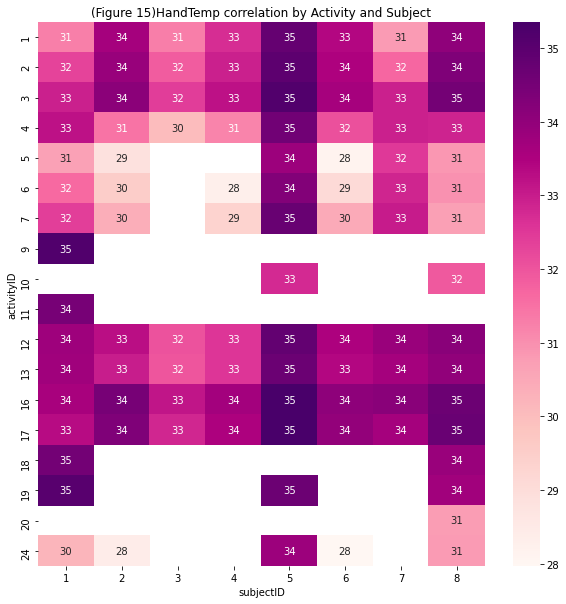

In [161]:
#Plot to view the correlation with different hand temperatures against the activity performed and the subject performing it
df = test_df.groupby(["activityID","subjectID"] , as_index=False).mean()[["activityID","subjectID","handTemp"]].pivot(index="activityID",columns="subjectID",values="handTemp")
fig=plt.figure(figsize=(10,10))
ax = fig.gca() 
sns.heatmap(df, cmap = "RdPu",annot= True)
ax.set_title("(Figure 15)HandTemp correlation by Activity and Subject");


Figure 15 clearly shows that subject 5 had higher overall heat throughout their entire body compared to the other subjects. It is noticeable that the temperatures are specific to the individuals and are affected by their specific bodies.


It is seen from figure 15 that activity 24 and activity 5 which are rope jump rope and running respectively had a low hand temperature over all subjects. These activities (looking at figure 14) also had a high overall heart rate from the subjects. This has led me to perform an analysis to determine if these two features are significantly linked: heart rate and hand temperature. Thus I believe that activities that are more demanding on the body (higher heart rate) will in turn reduce the temperature of the subject's hand.

## Section 3: Hypothesis testing
The purpose of hypothesis testing is to determine whether there is enough statistical evidence in favor of a certain belief, or hypothesis, about a parameter.

From the subjects that conducted both activity 2 and 24, those in activity 24 will have colder hand temperature compared to those in activity 24.
I present the following hypothesis test : 

### Hypothesis 1 )
**If increased heart rate reduces hand temperature then activites which are more physically demanding will in turn have lower hand temperature.**


$\mu_A$ = Mean hand temperature for activity 2(sitting)
$\mu_B$ = Mean hand temperature for activity 24(rope jumping)

$$ Null: H_0 : \mu_A = \mu_B$$
$$ Alternative: H_1 : \mu_A > \mu_B$$

$$t = \frac{(\bar{X_A} - \bar{X_B}) + (\mu_A - \mu_B)}{\sqrt{ \frac{S^2}{n_A} + \frac{S^2}{n_B} }}$$

From the calculations above and our two sample means are $\bar{X_A}$ and $X_B$, testing on the hypothesis $\mu_A$ and $\mu_B$ are equal which leads to the following used formula:
$$t = \frac{(\bar{X_A} - \bar{X_B})}{\sqrt{ \frac{S_A^2}{n_A} + \frac{S_B^2}{n_B} }}$$

We are going to perform a one tailed 99% confidence test which gives our $\alpha = 0.01$

This will be conducted using a z-test since the sample size is small - its the most suitable model.
This test is normally distributied where the difference between the means D is:
D ~ N $(\mu_A - \mu_B, \frac{\sigma_A^{2}}{n_1}  + \frac{\sigma_B^{2}}{n_2}) $

Since the size of the samples are sufficiently large, we an assume normal distribution by the Central Limit Theorem. The central limit theorem indicates that if the sample size is sufficiently large, the means of samples obtained using a random sampling with replacement are distributed normally with the mean, $µ$, and the variance, $σ^{2}_{n}$, regardless of the population distribution.$^{[3]}$

Bootstrapping is a vital ingredient to obtaining a valid nonbiased representation of the population. It is a statistical process for generating multiple simulated samples from a single dataset. For a variety of sample statistics, this procedure allows you to calculate standard errors, generate confidence intervals, and do hypothesis testing.


In [124]:
# bootstraps to remove fasle conculsions and a method to reduce inconsitencies in results
def bootstraps(df,activity,numsamples,feature):
    samples=[]
    
    for i in range(numsamples):
        samples.append(statistics.mean(np.random.choice(df[df["activityID"] == activity]
                                                        [feature],size=int((len(dev_df)*0.0001))))) #small sample used here 0.01% of the data 
        
    avg = statistics.mean(samples)
    stdavg = statistics.stdev(samples)
    return avg, stdavg,numsamples

### Testing the hypothesis on the development set

In [125]:
JRmean , JRstd, JRn = bootstraps(dev_df,24,30,"handTemp")
print (JRmean,JRstd,JRn)

29.73210725677831 0.12130961966969202 30


From the Jump rope bootstraps I have concluded that the average hand temperature from the 30 sample stake was $29.7^o$C with a standard deviation of $0.1896^o$C.

In [126]:
Smean,Sstd,Sn = bootstraps(dev_df,2,30,"handTemp")
print(Smean,Sstd,Sn)

33.26110446570973 0.0862422890414171 30


From the Sitting bootraps, it is concluded that the average han temperature from these 30 samples was $33.271^o$C. The standard deviation for these samples is $0.0721^o$C.

In [127]:
#method to quickly find the t score for conducted hypothesis test
def hypothesis(mu1,mu2,std1,std2,n1,n2):
    numerator= mu1 - mu2
    denominator= np.power((std1/n1)+(std2/n2),0.5)
    t= numerator/denominator
    return t

In [128]:
statistic = hypothesis(Smean,JRmean,Sstd,JRstd,JRn,Sn)
p_val = stats.t.sf(abs(statistic), JRn + Sn -2)
print("Our t value from this statistic: {:.4f}".format(statistic))
print("This has a corresponding p value {}".format(p_val))


Our t value from this statistic: 42.4276
This has a corresponding p value 1.1491355568438389e-45


Clearly, this indicates that the p-value is much much smaller than the given 95% confidence interval( even valid for 99% confidence interval). Therefore It is sufficient evidence to reject our null hypothesis $H_0$. Therefore we conclude that there is sufficient evidence to reject the null hypothesis and thus when participating in activities that are less demanding (lower BPM) the subject will have hotter hands. From here we are able to start roughly estimating the intensity of activity by just looking at the heart rate.

In [129]:
# when some tests were conducted I had a value of 0 for the p value. This is because my p values was
# much less than 2.225^-308
import sys
sys.float_info

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)

I will test activity 2 again against 4 (walking) which has a lower average heart rate whilst still being higher than the sitting activity. This would further strengthen my hypothesis and dictate that an increase in heart rate has a negative correlation with hand temperature.

From Figure 16 below: The respective heart rates in the order of mean I will select the following for testing:  Lying, Sitting,  Walking, Nordic Walking, Cycling, Running, Rope Jumping.  I will perform a statistical test on all of these values and hope to find that my alternative hypothesis is accepted for all activities that have a higher mean heart rate than sitting and thus hopefully only Lying will result in the null hypothesis being accepted.

In [130]:
OrderedHeartRate= [1,2,3,17,16,4,7,6,13,12,5,24]
activity = []
statistic= []
for i in range(len(OrderedHeartRate)): #iteration over all the heart rates
    activity.append(OrderedHeartRate[i])
    tempmean , tempstd, tempn = bootstraps(dev_df,OrderedHeartRate[i],30,"handTemp")
    statistic.append(hypothesis(Smean,tempmean ,Sstd,tempstd ,tempn ,Sn)) #appending to be able to plot after

In [131]:
p_values= []
for i in range(len(statistic)):
    p_values.append(stats.t.sf(abs(statistic[i]), 60 -2))

In [132]:
df = pd.DataFrame()
df["Activity"] = activity
df["Statistic"] = statistic
df["P Value"] = p_values

In [133]:
df

,Activity,Statistic,P Value
0,1,6.876940,2.358084e-09
1,2,0.049639,4.802904e-01
2,3,-5.663528,2.427169e-07
3,17,-10.875642,6.310182e-16
4,16,-13.762439,3.189498e-20
5,4,12.771459,8.445188e-19
6,7,21.963131,4.288117e-30
7,6,27.372364,3.708446e-35
8,13,-0.866843,1.947999e-01
9,12,-3.852466,1.473634e-04


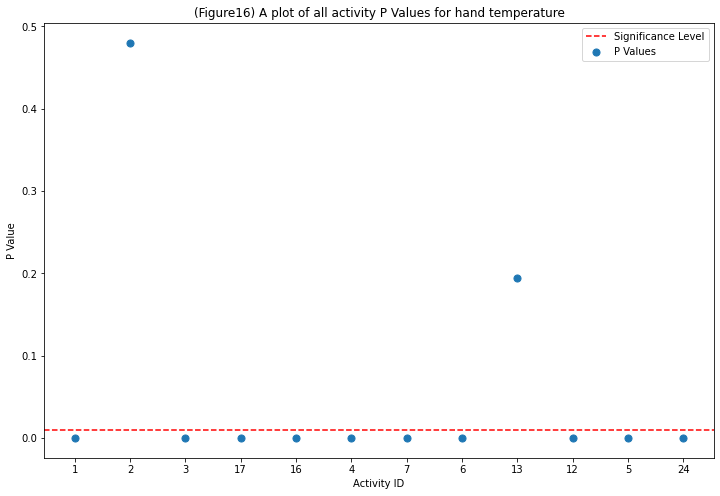

In [134]:
plt.figure(figsize=(12,8))
plt.scatter(list(map(str,activity)), p_values, s=50) # need to be mapped otherwise the data did not visualise
plt.xlabel("Activity ID")
plt.ylabel("P Value")
plt.axhline(y=0.01, color='r', linestyle='--')
plt.title("(Figure16) A plot of all activity P Values for hand temperature")
plt.legend(["Significance Level","P Values"])
plt.show()

Below I remove the obvious activities that cause the data to have misinformation. Figure 6 isn't scaled properly and there are two activities walking and ironing that we wish to remove. This is because clearly, the mean of hand temperature of walking compared to walking will not be statistically significant to reject the null hypothesis. Additionally, it makes sense that ironing would have an effect on the temperature of the hand and thus this activity causes injunctions to my hypothesis.

In [135]:
del activity[1] #deleting activities thta caused data to read incorrectly ^ explanation above as to why thus was done
del activity[-4]
del p_values[1]
del p_values[-4]

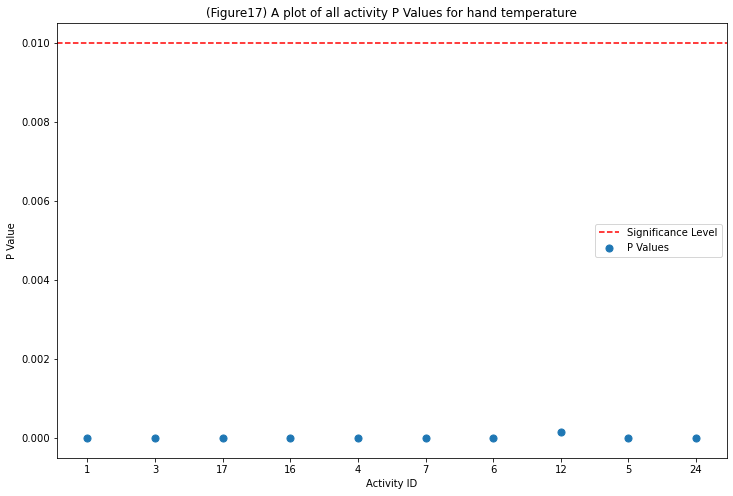

In [136]:
plt.figure(figsize=(12,8))
plt.scatter(list(map(str,activity)), p_values, s=50)
plt.xlabel("Activity ID")
plt.ylabel("P Value")
plt.axhline(y=0.01, color='r', linestyle='--')
plt.title("(Figure17) A plot of all activity P Values for hand temperature")
plt.legend(["Significance Level","P Values"])
plt.show()

It is now seen that every activity had sufficient evidence to reject the null hypothesis. This is contrary to my internal hypothesis that activity 1 should accept the null hypothesis. To explore this below I will perform another statistical hypothesis test to determine if the mean heart rate of activity 1 was significantly lower than activity 2. If this

### Hypothesis 2)

**If activity 1 rejected the previous null hypothesis then the mean heart rate of activity 1 (laying) is higher than the mean heart rate of activity 2 (sitting).**

To make sure that activities with higher heart rate produce less hand temperature, I need to ensure that the average heart rate for activity 1 is larger than that of activity 2.


$\mu_A$ = Mean heart rate for activity 1(laying)
$\mu_B$ = Mean heart rate for activity 2(sitting)

$$ Null: H_0 : \mu_A = \mu_B$$
$$ Alternative: H_1 : \mu_A > \mu_B$$

We are going to perform a one tailed 99% confidence test which gives our $\alpha = 0.01$


In [54]:
LayingHRmean , LayingHRstd, LayingHRn = bootstraps(dev_df,1,30,"heartrate")
print (LayingHRmean , LayingHRstd, LayingHRn)

75.7265710955711 0.5866143572528814 30


In [55]:
SittingHRmean , SittingHRstd, SittingHRn = bootstraps(dev_df,2,30,"heartrate")
print (SittingHRmean , SittingHRstd, SittingHRn)

80.0010894535329 0.451252695232282 30


In [56]:
statistic = hypothesis(LayingHRmean,SittingHRmean,LayingHRstd,SittingHRstd,LayingHRn,SittingHRn)
p_val = stats.t.sf(abs(statistic), LayingHRn + SittingHRn -2)
print("Our t value from this statistic: {:.4f}".format(statistic))
print("This has a corresponding p value {}".format(p_val))


Our t value from this statistic: -22.9814
This has a corresponding p value 4.040215710735038e-31


Here we see that the p-value for this test is $1.37^{-26}$ which is much lower than the threshold of $\alpha$. This indicates that the mean heart rate for activity 1 (laying) is not statistically equal to or lower than that of sitting. This strengthens my previous hypothesis and concludes why the activity of laying did not have a higher hand temperature. A real-life explanation for this could be due to when the subjects are laying down there is no gravity bringing blood to the hands and thus through poor circulation, the individuals did not have warmer hands for the "easier" activity.

## Section 4 : Classification


In [57]:
data = pamap2_df.drop(["activityID","timestamp","ActivityDifficulty"],axis=1)
#target = pamap2_df["activityID"]
target = pamap2_df["ActivityDifficulty"]

In [58]:
#seting up the split of the data
train_data,test_data,train_target,test_target = cross_validation.train_test_split(data,target,test_size=0.4,train_size=0.6)

In [59]:
def find_metrics(y_true,y_est): #easyily find metrics using a function to speed up my work
    
    accuracy = accuracy_score(y_true,y_est)
    error = 1- accuracy
    precision = precision_score(y_true,y_est,average = "macro",zero_division= 1).mean()
    recall = recall_score(y_true,y_est,average = "macro",zero_division =1 ).mean()
    f1 = f1_score(y_true,y_est,average="macro",zero_division= 1).mean()
    print("Accuracy = {:.4f} , Error = {:.4f} , Precison = {:.4f} , Recall = {:.4f} , F1-score =  {:.4f}".format(accuracy,error,precision,recall,f1))

### Logistic Regression

I intend to firstly use logistic regression to set estimates on my data. This is an easy-to-implement model and is also very efficient to train. Logistic Regression is used when the target variable is categorical which it is in this case ("Light", "Medium", "Vigorous"). Since we have a huge amount of data this implies that there will be no overfitting and make it a great tool to use. Additionally there is no assumptions of the distribution and thus is very unbiased. Here the data is being fit to the sigmoid function via stochastic gradient descent.

In [90]:
LogisticReg= LogisticRegression(max_iter=1000) 
#LogisticReg.fit(train_data,train_target)
#LogicPrediction = LogisticReg.predict(test_data)
#find_metrics(test_target,LogicPrediction)

#### The following codes will all take very long to run. I have recorded their results and spoke about them in the drop down cells.

#### Training the model using all calculates mean values

In [61]:
features_used = [ "handmean_acc16", "chestmean_acc16", "anklemean_acc16",
                "handmean_gyro", "chestmean_gyro", "anklemean_gyro",
                "handmean_temp", "chestmean_temp", "anklemean_temp"] #features we are training with
col_label= "ActivityDifficulty" #target variable

train_data= np.array(dev_df.loc[:,features_used])
train_labels= np.array(dev_df.loc[:,col_label])
LogisticReg.fit(train_data,train_labels)

test_data= np.array(test_df.loc[:,features_used]) #isolation of features above
test_labels= np.array(test_df.loc[:,col_label]) #target variable

predict_labels= LogisticReg.predict(test_data)


C:\Users\the-e\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
find_metrics(test_labels,predict_labels)

Accuracy = 0.7250 , Error = 0.2750 , Precison = 0.7336 , Recall = 0.5926 , F1-score =  0.6069


In [63]:
logic1_df = pd.DataFrame(find_metrics(test_labels,predict_labels))
logic1_df.to_csv("Logic1.csv", index= True)
Logic1 = pd.read_csv("Logic1.csv",index_col = 0)

Accuracy = 0.7250 , Error = 0.2750 , Precison = 0.7336 , Recall = 0.5926 , F1-score =  0.6069


Through Logistic Regression where the data was trained on only using the mean of the hand chest and ankle, 3-D Accelerations at scale 16g, 3-D gyroscopic, and temperature features from the IMUs. Logistic Regression had an accuracy of 72.5% of correct prediction which MET difficulty category the data resided in, this implies that the classifier will return more relevant results than the irrelevant ones. With a precision score of 73%, Recall 59%, and F1- 61%. The F1-score would be higher if the Recall was improved.

#### Training the model using everything

In [64]:
features_used = [ "handmean_acc16", "chestmean_acc16", "anklemean_acc16",
                "handmean_gyro", "chestmean_gyro", "anklemean_gyro",
                "handmean_temp", "chestmean_temp", "anklemean_temp",
                 'heartrate', 'handTemp', 'handAc16_1',
       'handAc16_2', 'handAc16_3', 'handGyro1', 'handGyro2', 'handGyro3',
       'handMag1', 'handMag2', 'handMag3', 'handOri4', 'chestTemp',
       'chestAc16_1', 'chestAc16_2', 'chestAc16_3', 'chestGyro1', 'chestGyro2',
       'chestGyro3', 'chestMag1', 'chestMag2', 'chestMag3', 'ankleTemp',
       'ankleAc16_1', 'ankleAc16_2', 'ankleAc16_3', 'ankleGyro1', 'ankleGyro2',
       'ankleGyro3', 'ankleMag1', 'ankleMag2', 'ankleMag3', ]
col_label= "ActivityDifficulty"

train_data= np.array(dev_df.loc[:,features_used])
train_labels= np.array(dev_df.loc[:,col_label])
LogisticReg.fit(train_data,train_labels)

test_data= np.array(test_df.loc[:,features_used])
test_labels= np.array(test_df.loc[:,col_label])

predict_labels= LogisticReg.predict(test_data)

C:\Users\the-e\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [65]:
find_metrics(test_labels,predict_labels)

Accuracy = 0.8773 , Error = 0.1227 , Precison = 0.8722 , Recall = 0.8203 , F1-score =  0.8412


This Logistic Regression model is much more efficient. This is due to the fact that there are more features that train the model and more data that is available to compare. Here the accuracy was found to be 88%, Precision 87%, Recall 82%, and F1-score 84%. These are very impressive numbers and would conclude that this model is very good at effectively classifying tasks into the three difficulty levels. However, this takes a long time to process and also results in overfitting. Below I have looked at other methods to classify the activities which take fractions of the time and also require much fewer measurements to maintain a decent amount of efficiency.

#### Training the model using only Acceleration Data (16g)

In [66]:
features_used = [ "handmean_acc16", "chestmean_acc16", "anklemean_acc16",
       'handAc16_2', 'handAc16_3','chestAc16_1', 'chestAc16_2', 'chestAc16_3',
       'ankleAc16_1', 'ankleAc16_2', 'ankleAc16_3']
col_label= "ActivityDifficulty"

train_data= np.array(dev_df.loc[:,features_used])
train_labels= np.array(dev_df.loc[:,col_label])
LogisticReg.fit(train_data,train_labels)

test_data= np.array(test_df.loc[:,features_used])
test_labels= np.array(test_df.loc[:,col_label])

predict_labels= LogisticReg.predict(test_data)

In [67]:
find_metrics(test_labels,predict_labels)

Accuracy = 0.6588 , Error = 0.3412 , Precison = 0.6667 , Recall = 0.5152 , F1-score =  0.5102


#### Training the model using only Gyroscope Data 

In [69]:
features_used = [ "handmean_gyro", "chestmean_gyro", "anklemean_gyro",
                'handGyro1', 'handGyro2', 'handGyro3','chestGyro1', 
                 'chestGyro2','chestGyro3','ankleGyro1', 'ankleGyro2',
       'ankleGyro3']

col_label= "ActivityDifficulty"

train_data= np.array(dev_df.loc[:,features_used])
train_labels= np.array(dev_df.loc[:,col_label])
LogisticReg.fit(train_data,train_labels)

test_data= np.array(test_df.loc[:,features_used])
test_labels= np.array(test_df.loc[:,col_label])

predict_labels= LogisticReg.predict(test_data)

In [70]:
find_metrics(test_labels,predict_labels)

Accuracy = 0.5680 , Error = 0.4320 , Precison = 0.6987 , Recall = 0.4317 , F1-score =  0.3943


#### Training the model using only Temp Data 

In [96]:
features_used = ["heartrate", "handmean_temp", "chestmean_temp", "anklemean_temp",
                'handTemp','chestTemp','ankleTemp']

col_label= "ActivityDifficulty"

train_data= np.array(dev_df.loc[:,features_used])
train_labels= np.array(dev_df.loc[:,col_label])
LogisticReg.fit(train_data,train_labels)

test_data= np.array(test_df.loc[:,features_used])
test_labels= np.array(test_df.loc[:,col_label])

predict_labels= LogisticReg.predict(test_data)

In [162]:
find_metrics(test_labels,predict_labels)

Accuracy = 0.8475 , Error = 0.1525 , Precison = 0.8502 , Recall = 0.7742 , F1-score =  0.8010


It is clear to see that when the classifier has every bit of information it performs tests the most effectively. However, this process is very time-consuming and it is of interest to find a model which performs very well with the most sparse amount of measurements required. From the previous sections- I am interested in temperature data as I noticed that this had an effect on the heart rate with a strong correlation. When the Logistic Regression classifier was trained using only this data, the metrics returned were substantial and had high rates for every score. This fills me with confidence as it implies that temperature alone is a great tool to analyse the type of activity performed. I aditionally looked at over types of variables to determine the activity level specifically: acceleration data and gyroscopic data. These were subpar indicators of the activity.

### Optimising Logistic Regression

In [86]:
grid ={"C":np.logspace(-3,3,7)}#"class_weight":["balanced","dict","None"],
       #'solver':['newton-cg', 'lbfgs', 'liblinear','sag','saga']}
logreg_cv=GridSearchCV(LogisticReg,grid,cv=4) #cv = k where k is the value for the k-folds.
logreg_cv.fit(train_data,train_labels)
print("Best Hyperparameters : {}".format(logreg_cv.best_params_))

Best Hyperparameters : {'C': 1000.0}


In [93]:
features_used = ["heartrate", "handmean_temp", "chestmean_temp", "anklemean_temp",
                'handTemp','chestTemp','ankleTemp']

col_label= "ActivityDifficulty"

LogisticReg= LogisticRegression(max_iter=1000,C= 1000) 


train_data= np.array(dev_df.loc[:,features_used])
train_labels= np.array(dev_df.loc[:,col_label])
LogisticReg.fit(train_data,train_labels)

test_data= np.array(test_df.loc[:,features_used])
test_labels= np.array(test_df.loc[:,col_label])

predict_labels= LogisticReg.predict(test_data)

C:\Users\the-e\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
find_metrics(test_labels,predict_labels)

Accuracy = 0.8533 , Error = 0.1467 , Precison = 0.8477 , Recall = 0.7828 , F1-score =  0.8068


Tuning several Hyperparameters resulted in the best values as stated above : "C = 1000.0 (in logspace). The other hyperparameter tuning did not run sucessfully and caused my kernel to crash. I have commented these out- you can see which ones I have attempted to research into.

The tuning of the Hyperparameters only slightly increased the metric scores for my logical regression classifier. With more time and more tuning the metric would increase however we need to think if its worth us doing so. (in practice -with alot of power - yes it would be).

### KMeans Cluster Classification

Data here needs to be standarised to the data set, this adjusts all values so that they are roughtly on the same scale. Here using scikit-learn has made this task alot simpler. Scale can be used which is similar to LinearRgression as we wish to create an instance of this that will fit all of the data I have been provided. Scale standarises the features to the same scale. Through lectures we used PCA. This was implemened in this section to reduce the dimensions of the data. This increases interpetability whilst maintaining information.

In [93]:
data = pamap2_df.drop(["timestamp","ActivityDifficulty"],axis=1)
#target = pamap2_df["activityID"]
target = pamap2_df["ActivityDifficulty"]

In [94]:
#seting up the split of the data
train_data,test_data,train_target,test_target = cross_validation.train_test_split(data,target,test_size=0.4,train_size=0.6)

In [95]:
x_train = train_data[["heartrate","handmean_temp", "chestmean_temp", "anklemean_temp",'handTemp','chestTemp','ankleTemp']]
x_test = test_data[["heartrate","handmean_temp", "chestmean_temp", "anklemean_temp",'handTemp','chestTemp','ankleTemp']]

In [177]:
x_train_scaled = scaler.fit(x_train)

In [169]:
pca = PCA(n_components=3, random_state= 0)

In [170]:
x_train_pca = (pca.fit_transform(x_train))

In [171]:
print(x_train_pca)

[[ 31.52747187  -2.32533201   0.088412  ]
 [ -8.51853875  -4.08354474   0.46804255]
 [ -6.51624602  -3.04749176  -0.91181146]
 ...
 [ 52.79088296   5.29051912   2.8910523 ]
 [ 10.70632536   1.71946808   2.80968624]
 [-35.32166651   6.22892085  -1.27028229]]


In [172]:
x_test_pca = pca.fit_transform(x_test)

In [173]:
model = cluster.KMeans(init = "random", n_clusters = 3,random_state=0)

In [174]:
model.fit(x_train_pca)

KMeans(init='random', n_clusters=3, random_state=0)

In [179]:
y_pred = model.predict(x_test_pca)

In [197]:
y_pred

array([1, 1, 2, ..., 1, 1, 2])

In [182]:
SC_3=silhouette_score(x_test,y_pred)
print('Silhouette Score = ', SC_3)

Silhouette Score =  0.5773064799664077


The silhouette score of 0.577 is a good metric score. Silhouette score ranges from -1 to 1. When the score is in the boundary [-1,0] this indicates that samples might have been assigned to the wrong cluster. Here 0.577 is a good score and since this classifier was trained using only temperatures and heart rate, this further indicates that temperature and heart rate a great tools to indicate physicaly activity level.

For the adjusted rand score - we need the true labels to be able to find the metric value. Below I will look at which activity have been assigned to which cluster.

In [201]:
print(test_target[:20])
print(y_pred[:20])

2256543       Light Activity
40103         Light Activity
95094         Light Activity
23929         Light Activity
957776        Light Activity
168277     Moderate Activity
1233758       Light Activity
1056220    Moderate Activity
1192121       Light Activity
1386896    Moderate Activity
1187709    Vigorous Activity
1075749    Moderate Activity
12970         Light Activity
815783     Moderate Activity
1305285    Moderate Activity
1483871       Light Activity
434959     Moderate Activity
2127477    Moderate Activity
50939         Light Activity
549794        Light Activity
Name: ActivityDifficulty, dtype: object
[1 1 2 1 1 2 1 2 2 2 0 2 1 2 1 1 2 2 1 1]


In [205]:
print(test_target[10:11])
print(y_pred[10:11])

1187709    Vigorous Activity
Name: ActivityDifficulty, dtype: object
[0]


We can see that light activities have been assigned to the cluster 1. with moderate activities to the cluster 2 and vigorous to cluster 0. From the first labels there was only one prediction of a cluster 0, which aligned to the only vigorous activity in the true labels.

In [206]:
def difficultyclassify(difficulty):
    if difficulty == "Light Activity":
        return 1
    if difficulty == "Moderate Activity":
        return 2
    if difficulty == "Vigorous Activity":
        return 0

In [207]:
test_target_mapped = test_target.apply(difficultyclassify)

In [209]:
test_target_mapped

2256543    1
40103      1
95094      1
23929      1
957776     1
          ..
1111246    2
1461252    1
1605303    2
2405073    2
801891     2
Name: ActivityDifficulty, Length: 978965, dtype: int64

In [223]:
aRS_3 = (adjusted_rand_score(test_target_mapped,y_pred)
print("Adjusted Rand Score = ",aRS_3)

Adjusted Rand Score =  -20.756070911907592


C:\Users\the-e\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\Users\the-e\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))


In [232]:
find_metrics(test_target_mapped, y_pred)

Accuracy = 0.8012 , Error = 0.1988 , Precison = 0.7889 , Recall = 0.7490 , F1-score =  0.7644


With metrics of 80% accuracy, 79% precision ,75% recall and 76% F1-score I belive that this cluster has done well with classifiying activities. Granted that Adjusted Rand Score and Silhouette Score are the proper metrics to use here, since I was unable to perform Adjusted Rand Score due to not knowing the "goldstandard" lables for the clusters (However I have attempted to find these in the section). I have included standard accuracy etc metrics for peace of mind.

### Decision Tree

I had difficulty using the Kmeans and therefore I have included a Decision Tree classifier. This classifier is one of the best for non linear data sets like ours. These are specially used for categorical variable targets such as ours. It is perfect for classification tasks. This is why I have implemented the Decision Tree Method.

In [47]:
clf = DecisionTreeClassifier(max_depth=3,criterion="entropy")
clf.fit(train_data,train_target)
predict_train = clf.predict(train_data)
predict_probability_train =clf.predict_proba(train_data)[:,1]

In [48]:
test_estimate =clf.predict(test_data)
probability_test_estimate = clf.predict_proba(test_data)[:,1]
Decisiontree_df = pd.DataFrame({"Test Target":test_target,
                               "Estimate Test":test_estimate,
                               "Test Estimation Probability":probability_test_estimate})

In [49]:
display(Decisiontree_df)

,Test Target,Estimate Test,Test Estimation Probability
2273030,Light Activity,Light Activity,0.046728
289437,Light Activity,Light Activity,0.012553
176711,Moderate Activity,Moderate Activity,0.626628
1101734,Moderate Activity,Moderate Activity,0.874708
886040,Moderate Activity,Moderate Activity,0.874708
...,...,...,...
220545,Vigorous Activity,Vigorous Activity,0.067427
596163,Light Activity,Light Activity,0.012553
2382337,Moderate Activity,Moderate Activity,0.649873
621263,Moderate Activity,Moderate Activity,0.649873


In [53]:
a = Decisiontree_df["Test Target"].tolist()
b = Decisiontree_df["Estimate Test"].tolist()
correct_predict = sum(1 for x,y in zip(a,b) if x==y)
print("The Decision Tree classifier has correctly predicted {:.4f}  % of exercises (accuracy)".format(100*(correct_predict/len(a))))

The Decision Tree classifier has correctly predicted 83.1862  % of exercises (accuracy)


The Decision Tree classifier has correctly predicted 83 % of exercies. 

In [52]:
predict_variable = clf.predict(test_data)
print(classification_report(test_target,predict_variable,zero_division= 0))

                   precision    recall  f1-score   support

   Light Activity       0.91      0.85      0.88    448303
Moderate Activity       0.76      0.90      0.82    419897
Vigorous Activity       0.93      0.51      0.66    110765

         accuracy                           0.83    978965
        macro avg       0.87      0.75      0.79    978965
     weighted avg       0.85      0.83      0.83    978965



Here there are great results for all metrics. The target labels have sucesfully been predicted and the model is a sucess at predicting labels for unknown data.

## Conclusion

The aim of this report was to produce actionable insight from the derived data set based on various measurements of movement and IMU data.

From the analysis of the data, there are several activities that induce a high average heart rate, that seem unintuitive. Figure 2 shows that descending stairs have the same average heart rate as that of ascending stairs and cycling. This is a huge find as these activities require MET much lower than the latter activities. This would be a great activity for an individual to utilise to allow them to train their cardiovascular health. Figure 5 (boxplot) solidifies this finding as the activity of descending stairs has a lower whisker much higher than that of ascending stairs. Here the upper quarter is higher than that of ascending stairs again, for an activity of MET 3 (descending stairs) and activity of MET 8 (ascending stairs). The difference between heart rates is astonishingly low and I would strongly recommend individuals with poor health to start descending stairs to import their overall health and fitness.

Figures 10,11 and 12 all compared the different average temperatures of the different placements of IMUs. Through looking at these graphs it is clear to see that more activities that had higher MET scores consistently resided in the bottom section of the average temperatures. With all the evidence I have gathered from the first couple of sections, this finally led me to conduct the hypothesis that activities that have higher MET scores result in the lower overall temperature of the body. My prediction that activities that have higher heart rates i.e in a higher MET category will have lower hand temperatures was analysed using a hypothesis test. This is based on the assumption that every activity had the same external heat and blood flow applied to the hand - which I had to check in my second hypothesis. The second hypothesis concluded that the activity that I was comparing as having a lower heart rate in fact did not statistically have a lower heart rate than the sitting activity. This is why when conduction the hypothesis test on all activities that it did not return the result I hypothesised. I made an accurate analysis that this was due to there not being statistical evidence of an altered heart rate compared to that of the comparison activity.

From my classification model task, I completed several methods with the Logistic Regression being the most effective at task classification. I resulted in a 76% accuracy, 74% precision, 64% recall, and 66% F1 score. This was using the calculated mean values for accel 16, gyro, and temperatures. Since my analysis through this report has been looking at the temperature - I also go on further onto only training the data with different features. The highest-scoring test was when every feature was used (obvious). I only included this for my sanity as it does not complete those requirements. I trained the data using Acceleration, Temperature, and Gyroscope data. From these three the most accurate one was that of the temperature data. I think that this is sufficient evidence that temperature data is a good method of classifying which activity a subject is performing.

I then used the KMeans clustering method to classify the data into clusters (3) from my 3 groups of MET. Here the Silhouette score and Adjusted Rand score are used. Accuracy is not a good measure for this type of data. Evaluation of the quality of the predicted clusters is used - this determines whether two cluster results are similar to each other.

### References:
[1] PAMAP2_Dataset: Physical Activity Monitoring. (n.d.). [ebook] Available at: http://archive.ics.uci.edu/ml/machine-learning-databases/00231/readme.pdf [Accessed 1st Dec. 2021].

[2] MET Table : Top End Sports [Website] Available at: https://www.topendsports.com/weight-loss/energy-met.html [Accessed 11th Dec.2021]

[3]Central limit theore: the cornerstone of modern statistics. [research paper] Available at: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5370305/ [Accessed 6th Dec.2021]

[4] MET Scores For Calories burnt. [Website] Available at : 
https://silvabackfitness.com/met-table/ [Accessed 2nd Jan. 2022]

In [233]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 437

import io
from nbformat import current

filepath="PAMPA2 Jupyter.ipynb"
question_count=0

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 4033


C:\Users\the-e\anaconda3\lib\site-packages\nbformat\current.py:15: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  warnings.warn("""nbformat.current is deprecated.
